### Test formation of quasicrystal by projection of high-dimentional unit cells

In [1]:
%matplotlib inline
from neurotools.nlab import *
import sys
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
import math

Loading nlab namespace
Could not locate the spectrum module, please install it
Multitaper methods will not work
Could not locate the spectrum module, please install it
Multitaper methods will not work


In [2]:
# Generate a collection of paths in M dimensions
# Use the unit vector projection to identify the point location
# TODO: we need a better datastructure for detecting identical points
# I don't know how to do this theoretically unless they occupy
# The same location in the higher-dimensional lattice?

# Hypothesis: two projections are identical if and only if their unit vectors agree? 
# This may speed things up?

In [3]:
# Dimensionality
M = 7
# Raster scale 
K = 20
# Raster resolution
S = 30000
# Unit vectors; make explicit no using complex this time
phases  = arange(M)*pi/M
rescale = 1.0/sqrt(0.5*M)
units   = np.float64([cos(phases),sin(phases)])#*rescale

In [4]:
units.T.dot(units)
units.dot(units.T)

array([[  3.50000000e+00,  -6.29019813e-17],
       [ -6.29019813e-17,   3.50000000e+00]])

### Brute force: project plane at high-res into hyperlattice

In [5]:
# Generate grid
def row_helper(i):
    x  = np.linspace(-K*0.01,K,S)
    y  = np.ones((S,))*x[i]
    # Lift 2D grid into unit basis (not uniquely constrained)
    # Quantize lifted points in higer dimensional unit basis
    quanta = np.int32(np.round(units.T.dot(np.array([x,y]))))
    # Remove duplicate points
    points = array(list(set(map(tuple,quanta.T)))).T
    # Project back to 2D
    return i,units.dot(points)

neurotools.jobs.parallel.reset_pool()
results = parmap(row_helper,arange(S),debug=False)
shadow  = np.concatenate([r.T for r in results]).T

NO POOL FOUND. STARTING



In [6]:
shadow.shape

(2, 2744298)

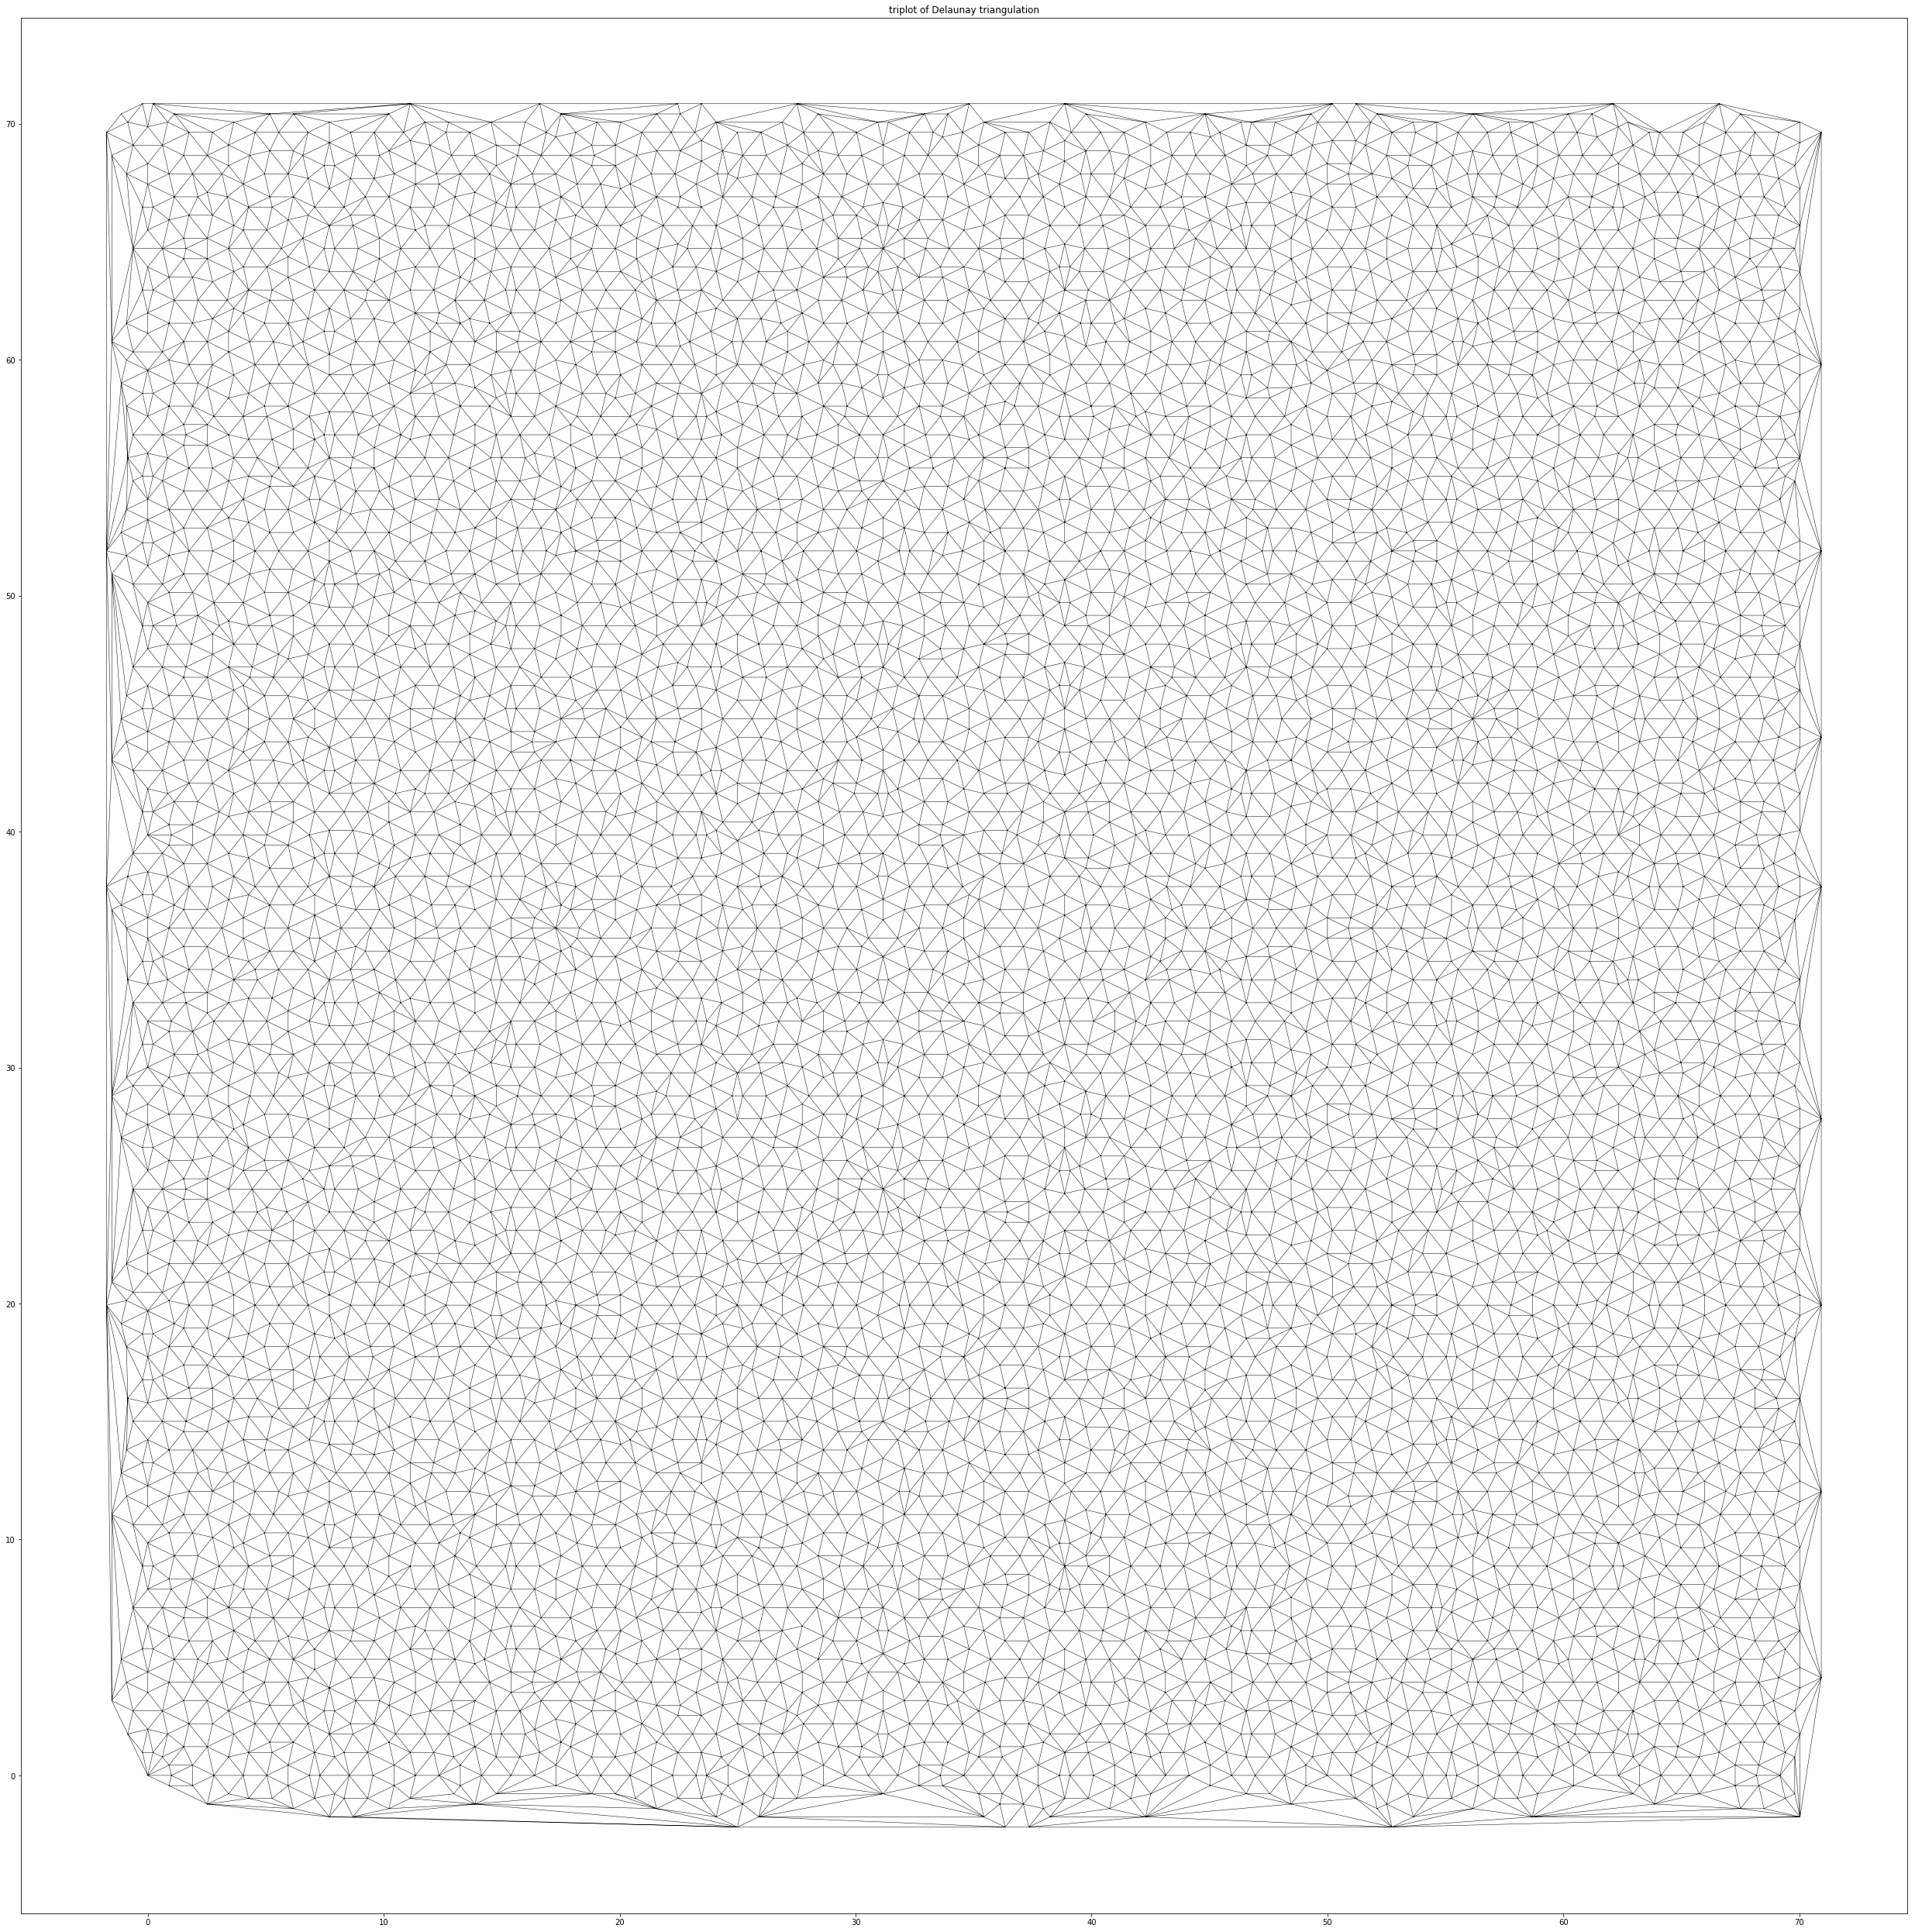

In [7]:
pp = shadow
# Create the Triangulation; no triangles so Delaunay triangulation created.
triang = tri.Triangulation(pp[0],pp[1])
# Plot the triangulation.
plt.figure(figsize=(45,45))
plt.gca().set_aspect('equal')
plt.triplot(triang, 'ko-', lw=0.5,markersize=0)
plt.title('triplot of Delaunay triangulation')
lima,limb = xlim()

In [8]:
# Compute edge lengths of triangles
xy = np.array([triang.x,triang.y])
z = np.array(triang.x) + 1j*np.array(triang.y)
tedgs = triang.triangles[:,[0,1,2,0]]
tpts = z[tedgs]
tedgelen = abs(diff(tpts,axis=1))
elens = tedgelen.ravel()

# Expected lengths of rhombus diagonals
ph = phases[1:M//2+1]
cp = cos(ph)
sp = sin(ph)
elen = sqrt(sp**2+(1-cp)**2)
elen = np.append([1],elen)#*rescale # add unit length

# Determine edge length ID (identifies tri shape)
near = abs(tedgelen[:,:,None]-elen[None,None,:])
edgeid = argmin(near,axis=2)

# Handle equilateral triangles specially
unit = find(abs(elen-1)<1e-3)
redund = unit!=0
if any(redund):
    replace = unit[redund]
    for id in replace:
        edgeid[edgeid==id] = 0

# Ok?
tok = sum(edgeid==0,axis=1)>=2
category = sum(edgeid,axis=1)
print('%0.2f%% triangles OK'%(100*mean(tok)))

# Generate a color map for triangles
cmapdata = neurotools.color.isolum_data
cmapdata.shape,
NC = (np.max(edgeid)+1)
cmap = cmapdata[(arange(NC)*cmapdata.shape[0])//NC,:]

98.45% triangles OK


In [9]:
rescale

0.53452248382484879

(0, 5)

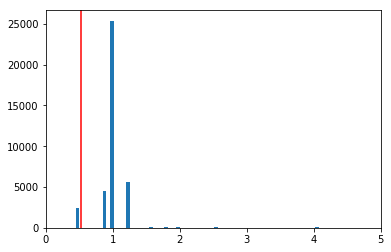

In [10]:
hist(elens,300);
axvline(rescale,color='r')
xlim(0,5)

In [11]:
tris = []
lins = []

njobs = len(tok)
for index in find(tok):
    t = triang.triangles[index]
    c = category[index]
    color = cmap[c%NC]
    pp = np.array([triang.x[t],triang.y[t]]).T
    p = plt.Polygon(pp,facecolor=color,edgecolor=color) ## PP is 3x2
    tris.append(p)
    if index%5==0:
        sys.stdout.write('\rTriangles prepared %0.1f%% '%((index+1)*100./njobs))
        sys.stdout.flush()
    
ee = triang.edges
ex = triang.x[ee]
ey = triang.y[ee]
dx = diff(ex,axis=1)
dy = diff(ey,axis=1)
dl = sqrt(dx*dx+dy*dy)
eps = 1e-3
unit = abs(dl-1)
eok = unit<eps
njobs = len(eok)
for eindex in find(eok):
    l = plt.Line2D(ex[eindex],ey[eindex],color='k',lw=1.5,antialiased=False)
    lins.append(l)
    if eindex%5==0:
        sys.stdout.write('\rEdges prepared %0.1f%%        '%((eindex+1)*100./njobs))
        sys.stdout.flush()

Edges prepared 100.0%        

Edges rendered 65.8%        
Showing final result...


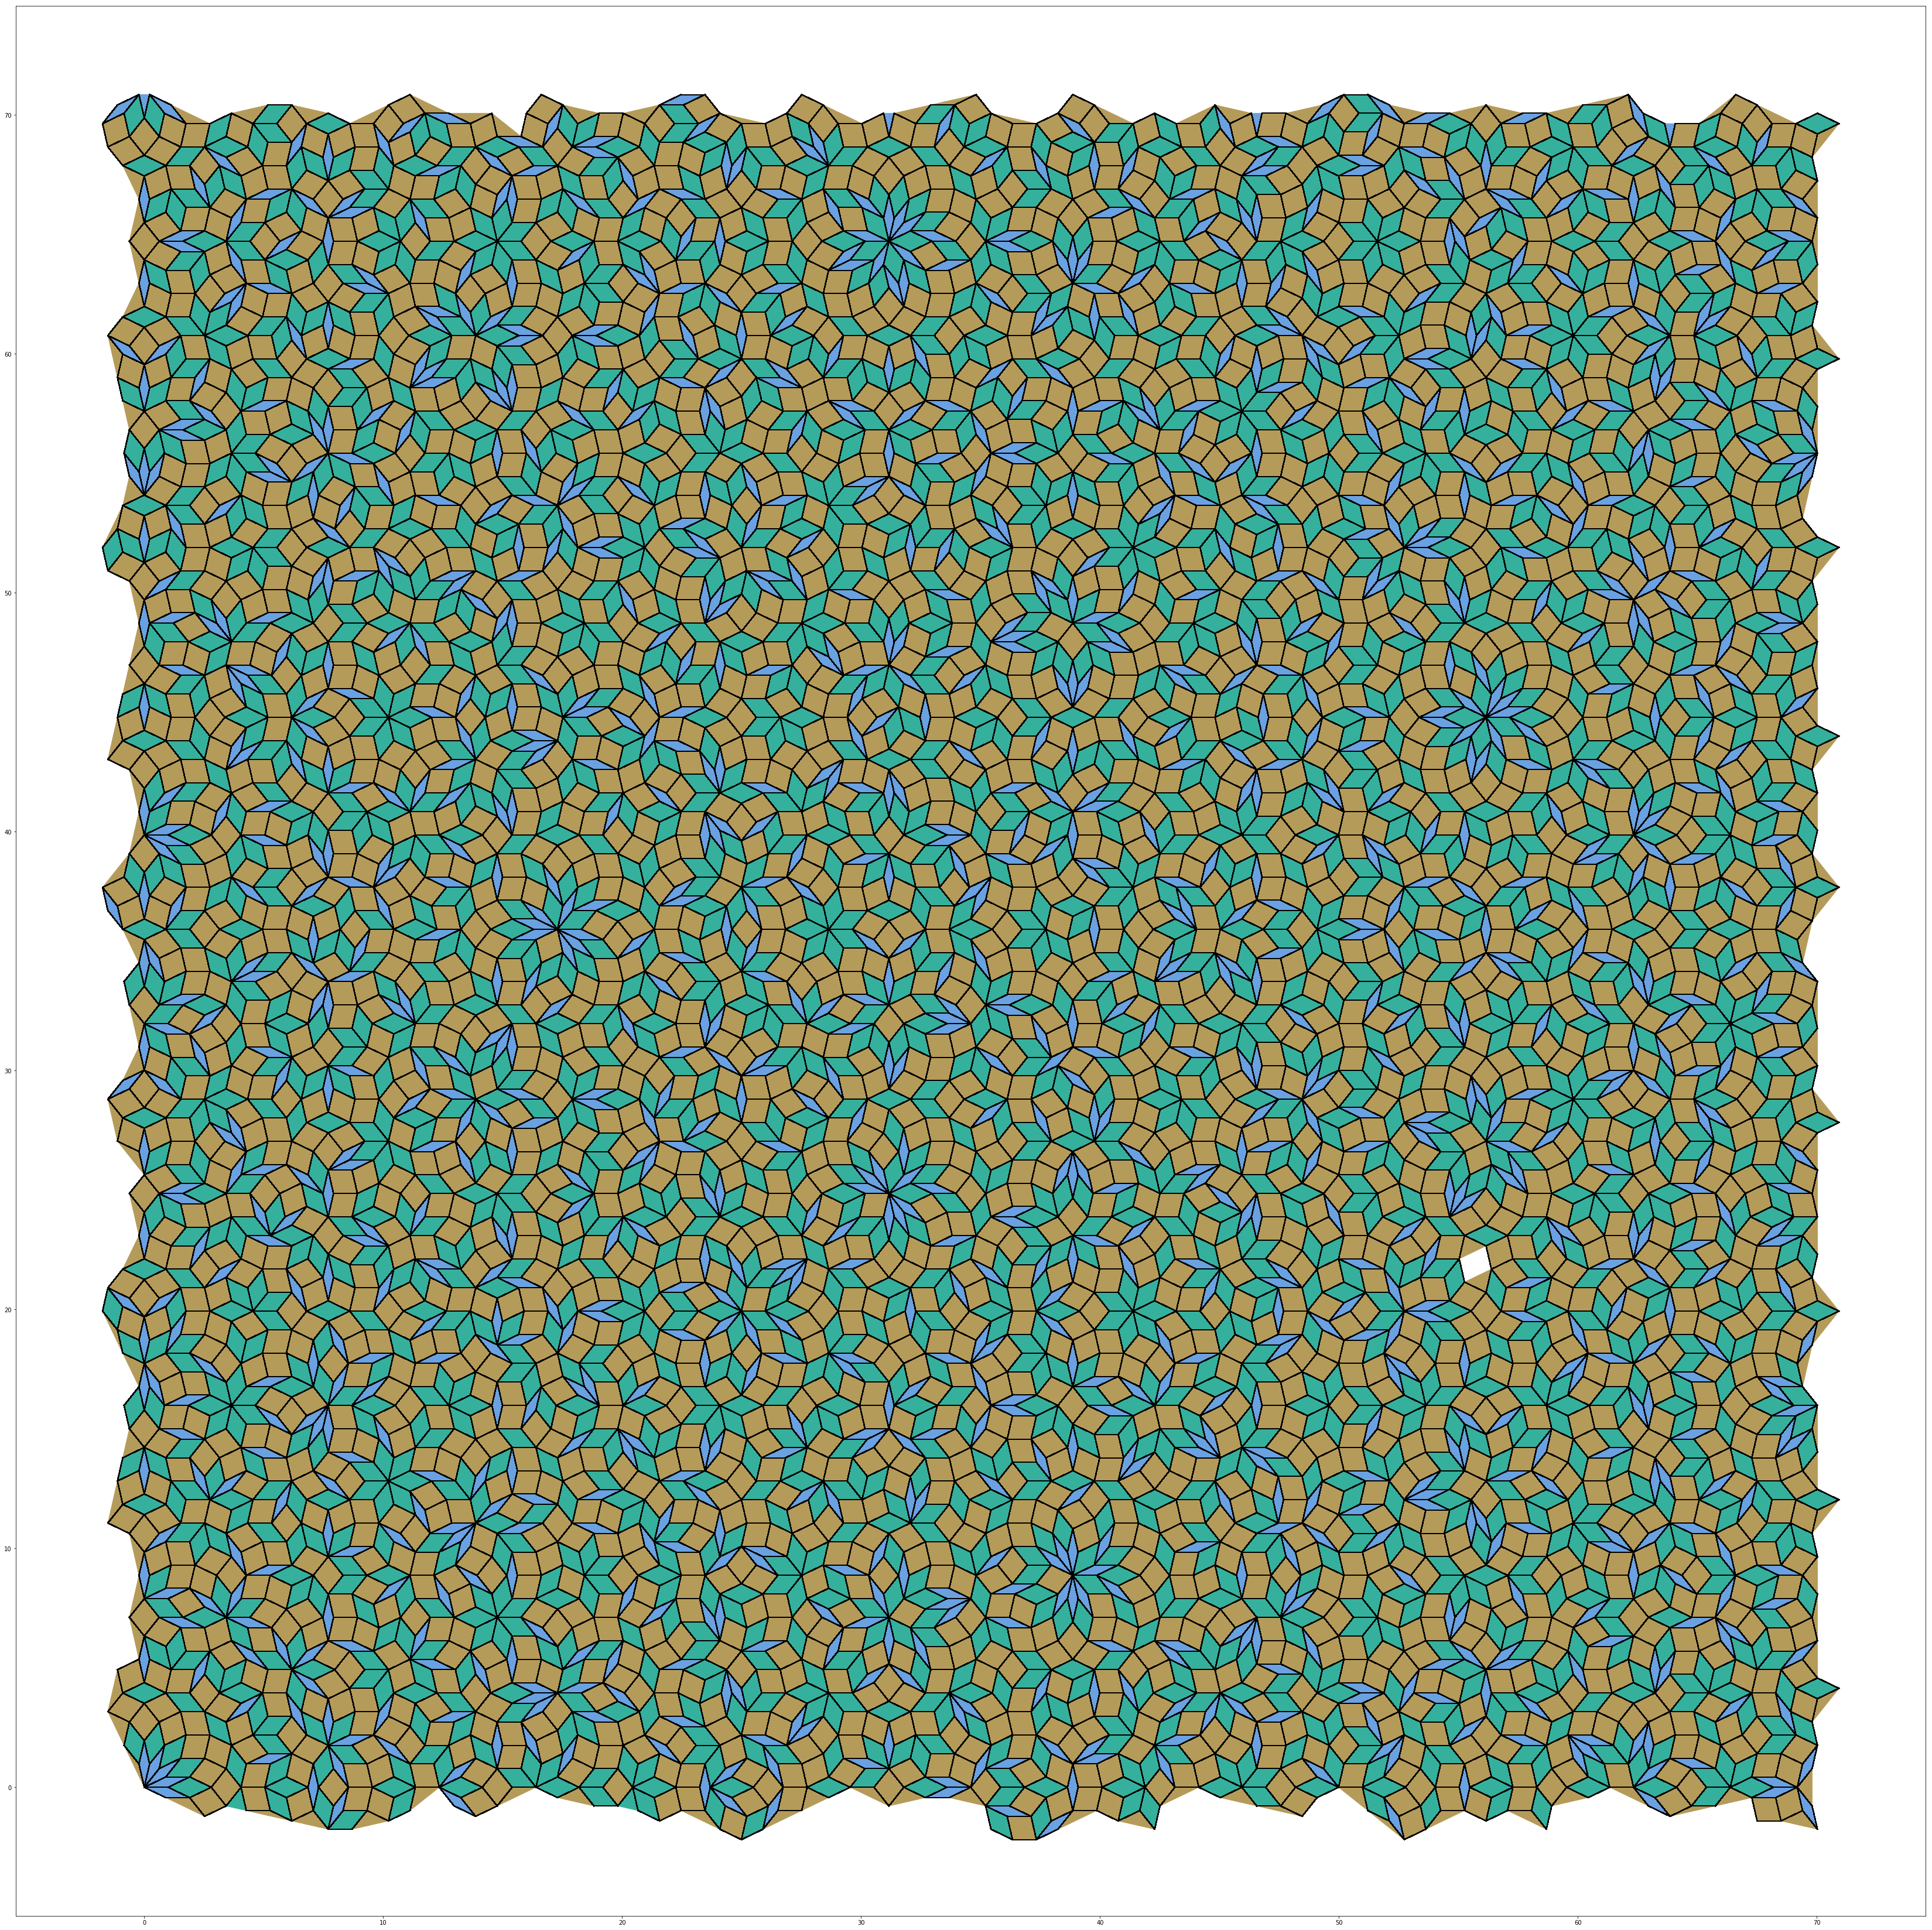

In [12]:
fig = figure(figsize=(60,60))
ax  = gca()    
xlim(lima,limb)
ylim(lima,limb)
force_aspect()

njobs = len(tok)
for index,p in enumerate(tris):
    ax.add_patch(p)
    if index%5==0:
        sys.stdout.write('\rTriangles rendered %0.1f%% '%((index+1)*100./njobs))
        sys.stdout.flush()

njobs = len(eok)
for eindex,l in enumerate(lins):
    ax.add_line(l)
    if eindex%5==0:
        sys.stdout.write('\rEdges rendered %0.1f%%        '%((eindex+1)*100./njobs))
        sys.stdout.flush()

sys.stdout.write('\nShowing final result...\n')
sys.stdout.flush()
plt.draw_all()